# Premier League 2023/24 predictions

## Importing libraries

In [84]:
import pandas as pd

# Load the dataset from the excel file
#file_path = 'all-euro-data-2023-2024.xlsx'
#df = pd.read_excel(file_path, sheet_name='E0')

# updating the dataset with the recent games played
df = pd.read_csv('E0.csv')

# Display the first few rows of the dataset
df.tail()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
173,E0,23/12/2023,15:00,Luton,Newcastle,1,0,H,1,0,...,2.02,1.00,1.82,2.11,1.76,2.18,1.88,2.18,1.80,2.08
174,E0,23/12/2023,15:00,Nott'm Forest,Bournemouth,2,3,A,0,0,...,1.93,0.00,2.13,1.81,2.13,1.82,2.17,1.83,2.08,1.80
175,E0,23/12/2023,15:00,Tottenham,Everton,2,1,H,2,0,...,2.49,-0.75,1.89,2.04,1.89,2.03,1.95,2.12,1.86,2.00
176,E0,23/12/2023,17:30,Liverpool,Arsenal,1,1,D,1,1,...,2.30,0.00,1.86,2.07,1.86,2.07,1.89,2.17,1.82,2.07
177,E0,24/12/2023,13:00,Wolves,Chelsea,2,1,H,0,0,...,2.09,0.25,1.98,1.95,2.01,1.92,2.06,1.95,1.96,1.89


## Data cleaning

In [85]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [86]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y')

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Columns: 106 entries, Div to AvgCAHA
dtypes: datetime64[ns](1), float64(82), int64(16), object(7)
memory usage: 147.5+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,2.02,2.00,1.92,1.95
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

## Encode team names

In [87]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])


## Recent form

In [88]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')



## Team Points

In [89]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)


## Head-to-Head Statistics

In [90]:
# Head-to-Head Statistics
# For simplicity, we can count the number of wins, draws, and losses in matches between the same teams
# Note: This implementation is simplified for demonstration purposes
def head_to_head_stats(home_team, away_team, df_cleaned):
    head_to_head_matches = df_cleaned[(df_cleaned['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)]
    wins = len(head_to_head_matches[head_to_head_matches['FTR'] == 'H'])
    draws = len(head_to_head_matches[head_to_head_matches['FTR'] == 'D'])
    losses = len(head_to_head_matches[head_to_head_matches['FTR'] == 'A'])
    return wins, draws, losses

# Apply the head-to-head stats function
df_cleaned['HeadToHeadWins'], df_cleaned['HeadToHeadDraws'], df_cleaned['HeadToHeadLosses'] = zip(*df_cleaned.apply(lambda x: head_to_head_stats(x['HomeTeam'], x['AwayTeam'], df_cleaned), axis=1))

In [91]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)
# 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage']].head())

      HomeTeam  HomeTeamWinPercentage       AwayTeam  AwayTeamWinPercentage
0      Burnley               0.111111       Man City               0.555556
1      Arsenal               0.777778  Nott'm Forest               0.111111
2  Bournemouth               0.250000       West Ham               0.444444
3     Brighton               0.444444          Luton               0.125000
4      Everton               0.333333         Fulham               0.111111


In [92]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AwayTeamRecentForm,HomeTeamAvgGoals,AwayTeamAvgGoals,HomeTeamPoints,AwayTeamPoints,HeadToHeadWins,HeadToHeadDraws,HeadToHeadLosses,HomeTeamWinPercentage,AwayTeamWinPercentage
0,E0,2023-08-11,20:00,Burnley,Man City,0,3,A,0,2,...,6,1.111111,2.000000,11,34,0,0,1,0.111111,0.555556
1,E0,2023-08-12,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,1,2.444444,0.777778,40,14,1,0,0,0.777778,0.111111
2,E0,2023-08-12,15:00,Bournemouth,West Ham,1,1,D,0,0,...,10,1.000000,1.555556,22,30,0,1,0,0.250000,0.444444
3,E0,2023-08-12,15:00,Brighton,Luton,4,1,H,1,0,...,6,2.000000,0.875000,27,12,1,0,0,0.444444,0.125000
4,E0,2023-08-12,15:00,Everton,Fulham,0,1,A,0,0,...,6,1.111111,1.000000,26,21,0,0,1,0.333333,0.111111


In [93]:
# get the current position and calculate points for chelsea and the rest of the teams
def calculate_points_goals(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']

    if row['FTR'] == 'H':
        home_points = 3
    elif row['FTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['FTHG'], row['FTAG']])

# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()
team_stats['GoalDiff'] = df_cleaned.groupby('HomeTeam')['HomeGoalDiff'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoalDiff'].sum()
team_stats['GoalsScored'] = df_cleaned.groupby('HomeTeam')['HomeGoals'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoals'].sum()

# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])

# Finding Chelsea's position
chelsea_position_updated = sorted_teams.index.get_loc('Chelsea') + 1
print('Chelsea is currently in position:', chelsea_position_updated)
sorted_teams.head(), chelsea_position_updated


Chelsea is currently in position: 11


(             Points  GoalDiff  GoalsScored
 Arsenal          40        20           36
 Liverpool        39        21           37
 Aston Villa      39        16           38
 Tottenham        36        13           37
 Man City         34        20           40,
 11)

## Data Preprocessing
### steps:
* Scaling Numeric Features: We'll scale features like recent form, average goals, and points using StandardScaler.
* Handling Categorical Variables: We have already encoded team names. We'll ensure other categorical features, if any, are properly encoded.
* Splitting the Data: We'll split the data into training and test sets. We'll use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage']
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning

In [95]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1)
    
}


## Creating the Objective Function so that we can use it in the hyperparameter optimization

In [96]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(6)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [97]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)


100%|██████████| 20/20 [05:43<00:00, 17.19s/trial, best loss: -0.6458333333333334]


In [98]:
from sklearn.metrics import classification_report

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
final_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           A       0.59      0.83      0.69        12
           D       0.20      0.20      0.20         5
           H       0.93      0.68      0.79        19

    accuracy                           0.67        36
   macro avg       0.57      0.57      0.56        36
weighted avg       0.71      0.67      0.67        36


In [99]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.6145833333333334


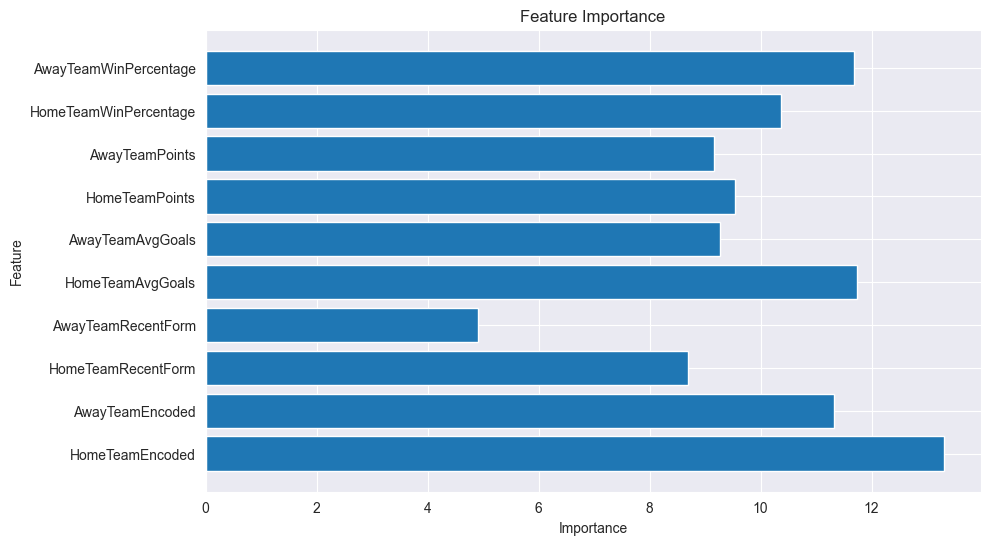

In [100]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [106]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

# newcastle vs nott'm forest
predict_match('Newcastle', "Nott'm Forest", final_model, scaler)

# bournemouth vs fulham
predict_match('Bournemouth', 'Fulham', final_model, scaler)

# sheffield vs luton
predict_match('Sheffield United', 'Luton', final_model, scaler)

# burnley vs liverpool
predict_match('Burnley', 'Liverpool', final_model, scaler)

# manchester utd vs aston villa
predict_match('Man United', 'Aston Villa', final_model, scaler)



Newcastle win probability: 0.055241058413123434
Nott'm Forest win probability: 0.8162900671780349
Draw probability: 0.12846887440884172
Bournemouth win probability: 0.5076711967144494
Fulham win probability: 0.22245061689522075
Draw probability: 0.2698781863903299
Sheffield United win probability: 0.2725610022546133
Luton win probability: 0.26016558583972677
Draw probability: 0.46727341190565985
Burnley win probability: 0.6532233374935702
Liverpool win probability: 0.07566433505874853
Draw probability: 0.2711123274476814
Man United win probability: 0.48516890417249886
Aston Villa win probability: 0.28017143970597713
Draw probability: 0.23465965612152406


(0.48516890417249886, 0.28017143970597713, 0.23465965612152406)

In [102]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train_smote)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.58      0.92      0.71        12
           D       0.25      0.20      0.22         5
           H       0.92      0.63      0.75        19

    accuracy                           0.67        36
   macro avg       0.58      0.58      0.56        36
weighted avg       0.71      0.67      0.66        36


In [103]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.625


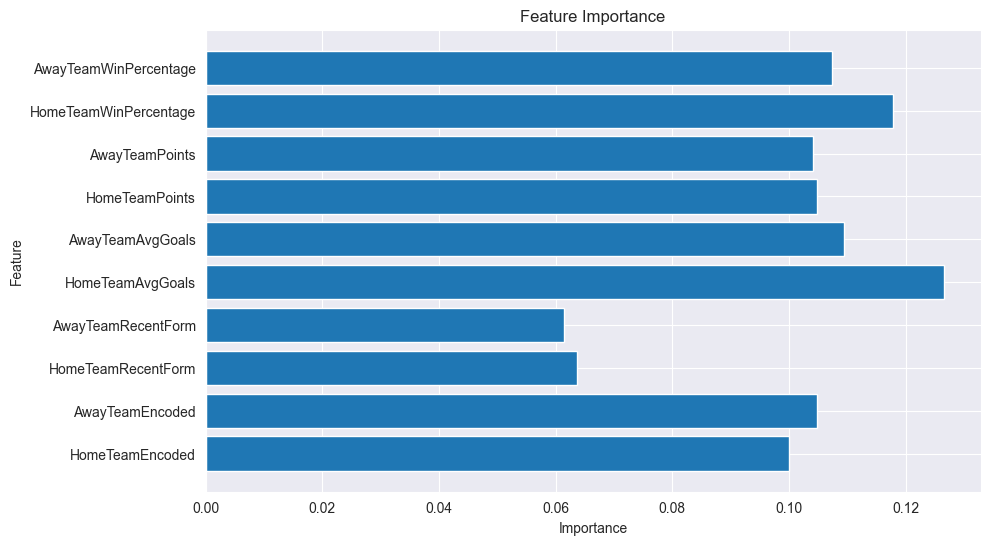

In [104]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [107]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
    draw_prob = best_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

# newcastle vs nott'm forest
predict_match('Newcastle', "Nott'm Forest", best_model, scaler)

# bournemouth vs fulham
predict_match('Bournemouth', 'Fulham', best_model, scaler)

# sheffield vs luton
predict_match('Sheffield United', 'Luton', best_model, scaler)

# burnley vs liverpool
predict_match('Burnley', 'Liverpool', best_model, scaler)

# manchester utd vs aston villa
predict_match('Man United', 'Aston Villa', best_model, scaler)


Newcastle win probability: 0.006666666666666667
Nott'm Forest win probability: 0.9333333333333333
Draw probability: 0.06
Bournemouth win probability: 0.4533333333333333
Fulham win probability: 0.16666666666666666
Draw probability: 0.38
Sheffield United win probability: 0.43
Luton win probability: 0.32
Draw probability: 0.25
Burnley win probability: 0.7633333333333333
Liverpool win probability: 0.0033333333333333335
Draw probability: 0.23333333333333334
Man United win probability: 0.5966666666666667
Aston Villa win probability: 0.20333333333333334
Draw probability: 0.2


(0.5966666666666667, 0.20333333333333334, 0.2)

In [ ]:
# compare the two models
from sklearn.metrics import classification_report

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# Evaluate the model
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))


In [ ]:
# plot the model comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the results
model_comparison = pd.DataFrame({'model': ['CatBoost', 'Random Forest'], 'accuracy': [0.59, 0.62]})
# Plot the results
plt.figure(figsize=(8, 6))

sns.barplot(x='model', y='accuracy', data=model_comparison)
plt.ylim(0, 1)
plt.title('Model Comparison')
plt.show()



In [ ]:
predict_match('Wolves', 'Chelsea', best_model, scaler)


In [ ]:
# save the model
import pickle

pickle.dump(best_model, open('best_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))



In [ ]:
# load the model
import pickle

best_model = pickle.load(open('best_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

